# Metagenomic-based Diagnostic for Sepsis

In [1]:
# Import Statements
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from pathlib import Path
cwd = Path.cwd()
datasets = cwd / 'datasets'
results = cwd / 'results'

ModuleNotFoundError: No module named 'xgboost'

## Data Preprocessing
Since we are using stratified kfold, a validation split is not necesssary.

### Load data

In [2]:
import pickle

with open(datasets / 'karius_genus_raw.pickle', 'rb') as f:
    X, y = pickle.load(f)
    
with open(datasets / 'karius_genus_pathogens.pickle', 'rb') as f:
    X_pathogens, _ = pickle.load(f)

# Binary encode y
y[y == 'septic'] = 1
y[y == 'healthy'] = 0
y = y.astype('int')

# Relative abundance
RA = X.apply(func=lambda x: x / x.sum(), axis=1)

### Train Test Split

In [3]:
from sklearn.model_selection import train_test_split

# Test data
X_idx, X_test_idx, y_train, y_test = train_test_split(X.index, y,
                                                shuffle=True,
                                                random_state=66,
                                                test_size=0.3,
                                                stratify=y)


def get_datasets(df, train_idx, test_idx):
    train = df.loc[train_idx, :]
    test = df.loc[test_idx, :]
    return train, test

raw_train, raw_test = get_datasets(X, X_idx, X_test_idx)
RA_train, RA_test = get_datasets(RA, X_idx, X_test_idx)

Here I print the number of examples for each split of data.

In [4]:
def get_metadata(y, df):
    pos = len(y[y == 1])
    neg = len(y[y == 0])
    row = pd.DataFrame({'Septic': [pos], 'Healthy': [neg]})
    df = df.append(row)
    return df


metadata = pd.DataFrame(columns=['Septic', 'Healthy'])
metadata = get_metadata(y_train, metadata)
metadata = get_metadata(y_test, metadata)
metadata.index = ['train', 'test']
display(metadata)

# Get negative to positive ratio
ratio = sum(y == 0) / sum(y == 1)

,Septic,Healthy
train,82,116
test,35,51


## Optimising model hyperparameters
We use gridsearch to do hyperparameter optimisation (n_estimators, max_depth).
n_estimators: Number of tree stumps
max_depth: max depth of nodes in tree stumps

In [5]:
def optimise(X, y):
    # Hyperparemeter Optimisation using grid search (F1)
    model = XGBClassifier()
    n_estimators = range(50, 300, 10)
    max_depth = range(1, 5, 1)
    gamma = [0.5, 1, 1.5, 2, 5]
    subsample = [0.6, 0.7, 0.8, 0.9, 1.0]
    colsample_bytree = np.linspace(0.1, 1, 10)
    print(max_depth)
    param_grid = dict(max_depth=max_depth, 
                      n_estimators=n_estimators, 
                      colsample_bytree=colsample_bytree,
                      gamma = gamma,
                     subsample = subsample,
                     scale_pos_weight = [ratio])
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=66)
    grid_search = GridSearchCV(model, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold, verbose=1)
    grid_result = grid_search.fit(X, y)
    # summarize results
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    # Print parameters and scores
#     for mean, stdev, param in zip(means, stds, params):
#         print("%f (%f) with: %r" % (mean, stdev, param))

    return(grid_result.best_params_)

### Optimise Model using Neat Data

In [6]:
# raw_params = optimise(raw_train, y_train)
raw_params = {'colsample_bytree': 0.1, 'gamma': 0.5, 'max_depth': 2, 'n_estimators': 140, 'scale_pos_weight': 1.4273504273504274, 'subsample': 0.6}

# RA_params = optimise(RA_train, y_train)
RA_params = {'colsample_bytree': 0.1, 'gamma': 1, 'max_depth': 1, 'n_estimators': 290, 'scale_pos_weight': 1.4273504273504274, 'subsample': 0.6}

### Model Training

In [7]:
raw_model = XGBClassifier(**raw_params)
raw_model.fit(X=raw_train, y=y_train)

RA_model = XGBClassifier(**RA_params)
RA_model.fit(X=RA_train, y=y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1, gamma=1,
              learning_rate=0.1, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=None, n_estimators=290, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.4273504273504274,
              seed=None, silent=None, subsample=0.6, verbosity=1)

### Evaluate Neat Data

In [8]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from imblearn.metrics import sensitivity_specificity_support

def evaluate(model, X_Test, y_Test):
    y_Pred = model.predict(X_Test)
    y_Score = model.predict_proba(X_Test)[:, 1]

    precision, recall, f1, _ = precision_recall_fscore_support(y_true=y_Test, y_pred=y_Pred, average='binary')
    sensitivity, specificity, _ = sensitivity_specificity_support(y_true=y_Test, y_pred=y_Pred, average='binary')
    auc = roc_auc_score(y_true=y_Test, y_score=y_Score)
    metric_df = pd.DataFrame({'F1':[f1],
                              'Sensitivity': [sensitivity],
                              'Specificity': [specificity],
                              'AUROC': [auc]})
    return metric_df


# Evaluate on test data
raw_metric = evaluate(raw_model, raw_test, y_test)
RA_metric = evaluate(RA_model, RA_test, y_test)

### Remove Contaminants based on SHAP values

In [9]:
import math
from scipy.stats import spearmanr
import shap


def decontam(X_train, y_train, params):
    model = XGBClassifier(**params)
    model.fit(X=X_train, y=y_train)

    explainer = shap.TreeExplainer(model, feature_pertubation='interventional', model_output='probability', data=X_train)
    shap_val = explainer.shap_values(X_train)

    to_retain = np.array([True] * X_train.shape[1])
    corrs = np.zeros(X_train.shape[1])

    for i in range(X_train.shape[1]):
        rho = spearmanr(X_train.iloc[:, i], shap_val[:, i])[0]
        p = spearmanr(X_train.iloc[:, i], shap_val[:, i])[1]
        if rho < 0 and p < 0.05:
            to_retain[i] = False

        if math.isnan(rho):
            corrs[i] = 2
        else:
            corrs[i] = rho

    to_retain = np.logical_and(corrs > 0, corrs != 2)
    to_retain = X_train.columns[to_retain]
    print(to_retain.shape, to_retain)
    return to_retain

In [10]:
genera_new = raw_train.columns
for _ in range(10):
    genera_new = decontam(raw_train[genera_new], y_train, raw_params)

invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in less_equal


(61,) Index(['Rhodopseudomonas', 'Afipia', 'Agrobacterium', 'Starkeya',
       'Novosphingobium', 'Azospirillum', 'Citrobacter', 'Escherichia',
       'Klebsiella', 'Salmonella', 'Proteus', 'Moraxella', 'Pseudomonas',
       'Stenotrophomonas', 'Aeromonas', 'Acidovorax', 'Delftia', 'Polaromonas',
       'Diaphorobacter', 'Rhodoferax', 'Ottowia', 'Cupriavidus',
       'Burkholderia', 'Pandoraea', 'Paraburkholderia', 'Campylobacter',
       'Bacteroides', 'Prevotella', 'Microbacterium', 'Rothia', 'Cellulomonas',
       'Actinomyces', 'Bifidobacterium', 'Streptococcus', 'Bacillus',
       'Lachnoclostridium', 'Blautia', 'Roseburia', 'Veillonella',
       'Fusobacterium', 'Betapolyomavirus', 'Cytomegalovirus', 'Enterococcus',
       'Flavonifractor', 'Pseudopropionibacterium', 'Tessaracoccus',
       'Methylocystis', 'Haemophilus', 'Enterobacter', 'Neisseria',
       'Sulfuritortus', 'Tannerella', 'Cloacibacterium', 'Shigella',
       'Shewanella', 'Meiothermus', 'Lymphocryptovirus', 'Thio

In [11]:
to_retain = list(set(genera_new).intersection(set(X_pathogens.columns)))
print(to_retain)

['Alphatorquevirus', 'Shewanella', 'Lachnoclostridium', 'Betapolyomavirus', 'Pandoraea', 'Enterobacter', 'Burkholderia', 'Escherichia', 'Enterococcus', 'Stenotrophomonas', 'Lymphocryptovirus', 'Prevotella', 'Bifidobacterium', 'Veillonella', 'Campylobacter', 'Shigella', 'Cellulomonas', 'Blautia', 'Cytomegalovirus', 'Salmonella', 'Agrobacterium', 'Tannerella', 'Aeromonas', 'Bacillus', 'Proteus']


In [12]:
# Decontam + pathogens
raw_SS = X_pathogens[to_retain]


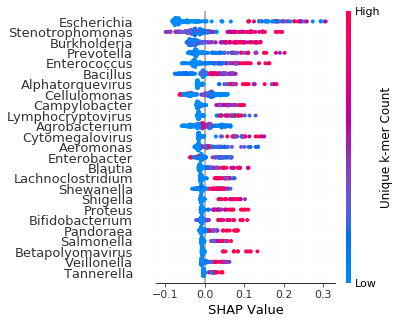

In [13]:
# Get SHAP summary before removing Cellulomonas and Agrobacterium
pre_SS_train, pre_SS_test = get_datasets(raw_SS, X_idx, X_test_idx)
pre_model = XGBClassifier(**raw_params)
pre_model.fit(X=pre_SS_train, y=y_train)

pre_explainer = shap.TreeExplainer(pre_model, feature_pertubation='interventional', model_output='probability', data=pre_SS_train)
shap_pre = pre_explainer.shap_values(pre_SS_train)

shap.summary_plot(shap_pre, pre_SS_train, show=False, plot_size=(4, 5), color_bar_label='Unique k-mer Count', max_display=25)
fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel('SHAP Value')
plt.savefig(results / 'pre_shap.png', dpi=1200, format='png', bbox_inches='tight')


### Drop features

In [14]:
raw_SS = raw_SS.drop(['Cellulomonas', 'Agrobacterium'], axis=1)
print(f'Removed {len(genera_new) - len(to_retain)} genera')
# print(f"Genera from list not removed:\n {set(meta) - set(to_remove)}")
print(f'New shape  = {raw_SS.shape}')

Removed 3 genera
New shape  = (284, 23)


In [15]:
# Normalise Datasets
RA_SS = raw_SS.apply(func=lambda x: x / x.sum(), axis=1)

# Get train test split
raw_SS_train, raw_SS_test = get_datasets(raw_SS, X_idx, X_test_idx)
RA_SS_train, RA_SS_test = get_datasets(RA_SS, X_idx, X_test_idx)

### Number of Features

In [16]:
print('Neat', X.shape)
print('Pathogens', raw_SS.shape)

Neat (284, 1056)
Pathogens (284, 23)


### Optimise SS Models

#### Pathogens

In [17]:
# raw_SS_params = optimise(raw_SS_train, y_train)
raw_SS_params = {'colsample_bytree': 0.1, 'gamma': 1, 'max_depth': 3, 'n_estimators': 270, 'scale_pos_weight': 1.4273504273504274, 'subsample': 1.0}

In [18]:
# RA_SS_params = optimise(RA_SS_train, y_train)
RA_SS_params = {'colsample_bytree': 0.2, 'gamma': 1, 'max_depth': 4, 'n_estimators': 70, 'scale_pos_weight': 1.4273504273504274, 'subsample': 0.6}

## Fit optimised models

In [19]:
# Fit optimised model on all training data

# Decontam
raw_SS_model = XGBClassifier(**raw_SS_params)
raw_SS_model.fit(X=raw_SS_train, y=y_train)

RA_SS_model = XGBClassifier(**RA_SS_params)
RA_SS_model.fit(X=RA_SS_train, y=y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2, gamma=1,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=70, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.4273504273504274,
              seed=None, silent=None, subsample=0.6, verbosity=1)

## Evaluate model

In [20]:
raw_SS_metric = evaluate(raw_SS_model, raw_SS_test, y_test)
RA_SS_metric = evaluate(RA_SS_model, RA_SS_test, y_test)

raw_SS_metric = evaluate(raw_SS_model, raw_SS_test, y_test)
RA_SS_metric = evaluate(RA_SS_model, RA_SS_test, y_test)

metric_df = pd.concat([raw_metric,
                       RA_metric,
                       raw_SS_metric,
                       RA_SS_metric], axis=0)
metric_df.index = ['Raw', 'RA', 'Raw SS', 'RA SS']
display(metric_df.round(3))

,F1,Sensitivity,Specificity,AUROC
Raw,0.986,1.000,0.980,0.999
RA,0.930,0.943,0.941,0.993
Raw SS,0.914,0.914,0.941,0.943
RA SS,0.886,0.886,0.922,0.959


### Confidence Intervals (non-parametric boostrap estimates)

Bootstrap with 1001 iterations, 95% CI

In [21]:
def get_percentiles(x, alpha=0.05):
    low = np.percentile(x, alpha / 2 * 100)
    high = np.percentile(x, (1 - alpha / 2) * 100)
    
    return low, high


np.random.seed(66)
from sklearn.utils import resample


def get_confint(model, X_test, y_test, n_iter=1001):
    boot_df = pd.DataFrame({'F1': [0], 'Sensitivity': [0], 'Specificity': [0], 'AUROC' : [0]})
    
    for _ in range(n_iter):
        boot_X, boot_y = resample(X_test, y_test, n_samples=len(y_test), replace=True, stratify=y_test)
        y_pred = model.predict(boot_X)
        y_score = model.predict_proba(boot_X)[:, 1]

        sensitivity, specificity, _ = sensitivity_specificity_support(y_true=boot_y, y_pred=y_pred, average='binary')
        precision, recall, f1, _ = precision_recall_fscore_support(y_true=boot_y, y_pred=y_pred, average='binary')
        auc = roc_auc_score(y_true=boot_y, y_score=y_score)
        temp_df = pd.DataFrame({'F1': [f1], 'Sensitivity': [sensitivity], 
                                'Specificity': [specificity], 'AUROC' : [auc]})
        
        boot_df = pd.concat([boot_df, temp_df], axis=0)
    
    boot_df = boot_df.iloc[1:, :]
    
    confints = [get_percentiles(boot_df[col]) for col in boot_df.columns]
    display(pd.DataFrame(confints, 
                         columns=['2.5%', '97.5%'], 
                         index=boot_df.columns).transpose().round(3))
    

In [22]:
print('Raw:', end='')
get_confint(raw_model, raw_test, y_test)
print('RA:', end='')
get_confint(RA_model, RA_test, y_test)

print('Raw SS:', end='')
get_confint(raw_SS_model, raw_SS_test, y_test)
print('RA SS:', end='')
get_confint(RA_SS_model, RA_SS_test, y_test)

Raw:

,F1,Sensitivity,Specificity,AUROC
2.5%,0.959,1.0,0.941,0.997
97.5%,1.000,1.0,1.000,1.000


RA:

,F1,Sensitivity,Specificity,AUROC
2.5%,0.873,0.886,0.863,0.981
97.5%,0.986,1.000,1.000,1.000


Raw SS:

,F1,Sensitivity,Specificity,AUROC
2.5%,0.841,0.829,0.863,0.884
97.5%,0.971,1.000,1.000,0.988


RA SS:

,F1,Sensitivity,Specificity,AUROC
2.5%,0.800,0.771,0.843,0.903
97.5%,0.957,0.971,0.980,0.991


## Interpreting model using SHAP values

### Feature importance
This is a plot of mean absolute SHAP values per feature

### Plot of SHAP values per Feature

In [23]:
import matplotlib.pyplot as plt
explainer_SS = shap.TreeExplainer(raw_SS_model, feature_pertubation='interventional', model_output='probability', data=raw_SS_train)
shap_SS = explainer_SS.shap_values(raw_SS_test)

explainer_raw = shap.TreeExplainer(raw_model, feature_pertubation='interventional', model_output='probability', data=raw_train)
shap_raw = explainer_raw.shap_values(raw_test)

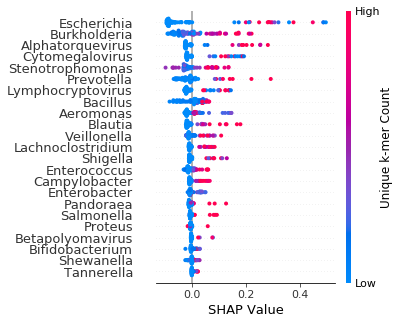

In [24]:
shap.summary_plot(shap_SS, raw_SS_test, show=False, plot_size=(4, 5), color_bar_label='Unique k-mer Count', max_display=35)
fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel('SHAP Value')
plt.savefig(results / 'SS_shap.png', dpi=1200, format='png', bbox_inches='tight')

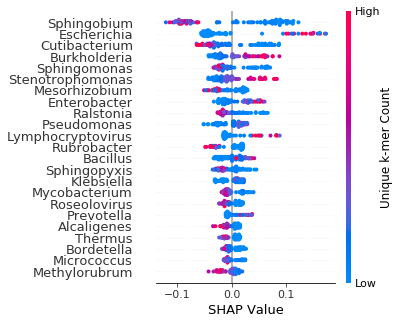

In [25]:
shap.summary_plot(shap_raw, raw_test, show=False, plot_size=(4, 5), color_bar_label='Unique k-mer Count', max_display=23)
fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel('SHAP Value')
plt.savefig(results / 'raw_shap.png', dpi=1200, format='png', bbox_inches='tight')

* Features are ranked by importance from top to botttom
* feature values are the kmer counts for each genus
* SHAP values are the average marginal contributions to probability

### Force plot for healthy patient

Actual Classification 1
SRR8288754


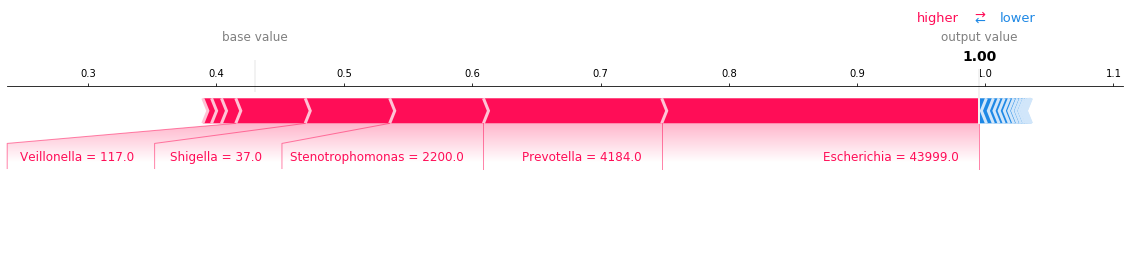

In [26]:
j = 72
print(f'Actual Classification {y_test[j]}')
print(raw_SS_test.index[j])
shap.force_plot(explainer_SS.expected_value, 
                shap_SS[j,:], 
                raw_SS_test.iloc[j,:],
                show=False,
                matplotlib=True)
plt.savefig(results / 'SS_force_plot.png', dpi=1200, format='png', bbox_inches='tight')

## How much does Escherichia drive predictions?

In [27]:
escherichia_idx = raw_SS_test.columns.get_loc('Escherichia')

In [28]:
y_score = raw_SS_model.predict_proba(raw_SS_test)[:, 1]
old_auc = roc_auc_score(y_true=y_test, y_score=y_score)
new_auc = roc_auc_score(y_true=y_test, y_score=y_score - shap_SS[:, escherichia_idx])
print(f"Before Removing Escherichia = {old_auc}\nAfter Removing Escherichia = {new_auc}")

Before Removing Escherichia = 0.9434173669467788
After Removing Escherichia = 0.8773109243697479
